In [36]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

##### Loading data

In [37]:
# Dicts to identify which countries go with which tickers (all are 10-year Govt yields)
codes = {}
codes['US'] = 'USGG10YR'
codes['Germany'] = 'GDBR10'
codes['UK'] = 'GUKG10'
codes['France'] = 'GFRN10'
codes['Australia'] = 'GACGB10'
codes['Canada'] = 'GCAN10YR'
codes['New Zealand'] = 'GNZGB10'
codes['Japan'] = 'JGBS10'
codes['Switzerland'] = 'GSWISS10'
codes['Norway'] = 'GNOR10YR'
codes['Italy'] = 'GBTPGR10'

codes_back = {}
for key, value in codes.items():
    codes_back[value] = key

sheet_names = pd.ExcelFile('G10_RV.xlsx').sheet_names

# Combining data into single df
for i, x in enumerate(sheet_names):
    if i == 0:
        df = pd.read_excel('G10_RV.xlsx', sheet_name=x)[['Date', 'Last Price']]
        df.columns = ['Date', x]
    else:
        new_df = pd.read_excel('G10_RV.xlsx', sheet_name=x)[['Date', 'Last Price']]
        new_df.columns = ['Date', x]
        df = df.merge(new_df, on='Date', how='outer')

# Filling in missing days with previous observations, defining which columns are rates we want
df = df.set_index('Date')
df = df.resample('D').asfreq()
df = df.ffill()
df = df[::-1].dropna()
rates_tickers = df.columns[:11]

df.head()

,USGG10YR,GDBR10,GUKG10,GFRN10,GACGB10,GCAN10YR,GNZGB10,JGBS10,GSWISS10,GNOR10YR,GBTPGR10,EURUSD,GBPUSD,USDCAD,AUDUSD,NZDUSD,USDJPY,USDNOK,USDCHF,USGG12M
Date,,,,,,,,,,,,,,,,,,,,
2024-03-29,4.2003,2.298,3.933,2.809,3.962,3.468,4.540,0.750,0.687,3.572,3.681,1.0790,1.2623,1.3540,0.6521,0.5980,151.35,10.8260,0.9014,5.0238
2024-03-28,4.2003,2.298,3.933,2.809,3.962,3.468,4.540,0.730,0.687,3.572,3.681,1.0789,1.2624,1.3540,0.6516,0.5973,151.38,10.8567,0.9017,5.0238
2024-03-27,4.1903,2.292,3.932,2.789,4.000,3.440,4.567,0.738,0.689,3.572,3.613,1.0828,1.2640,1.3568,0.6535,0.6004,151.33,10.7797,0.9038,4.9877
2024-03-26,4.2316,2.350,3.971,2.835,4.025,3.498,4.565,0.757,0.723,3.606,3.653,1.0831,1.2628,1.3584,0.6533,0.6004,151.56,10.7568,0.9040,4.9882
2024-03-25,4.2454,2.372,3.988,2.850,4.006,3.489,4.502,0.752,0.680,3.599,3.694,1.0837,1.2636,1.3586,0.6540,0.6003,151.42,10.7165,0.8994,4.9587


### Simple Linear Model
##### Choose one of the rates as a target, and use the others as predictors. We choose a given t value, and then calculate continuous changes in all rates for that t value. Then we regress changes in target against changes in predictors

In [215]:
def simple(t):
    data = df[rates_tickers].copy()
    # Calculating our changes
    for ticker in data:
        data[f'{ticker}_c'] = data[ticker].diff(-t)

    #Train, test split
    data = data.dropna()
    changes = data[[x for x in data if x.endswith('_c')]]
    changes_training = changes[changes.index < '2023-1-1']
    changes_testing = changes[changes.index >= '2023-1-1']
    causalities = pd.DataFrame()
    causalities['Predictor'] = [codes_back[x] for x in rates_tickers] + ['', 'Training r2', 'Testing r2']

    # Building model and storing results for each rate as the target, making df to see results
    for i, target in enumerate(changes.columns):
        training_X = changes_training[[x for x in changes_training if x != target]]
        training_y = changes_training[target]
        testing_X = changes_testing[[x for x in changes_testing if x != target]]
        testing_y = changes_testing[target]
        model = LinearRegression()
        model.fit(training_X, training_y)
        training_prediction = model.predict(training_X)
        testing_prediction = model.predict(testing_X)
        training_r2 = r2_score(training_y, training_prediction)
        testing_r2 = r2_score(testing_y, testing_prediction)
        coefficients = [round(x,2) for x in model.coef_]
        coefficients.insert(i, None)
        coefficients.insert(len(coefficients), '')
        coefficients.insert(len(coefficients), round(training_r2, 2))
        coefficients.insert(len(coefficients), round(testing_r2, 2))
        causalities[f'y: {codes_back[target[:-2]]}'] = coefficients
    causalities['ABS Mean'] = [causalities.iloc[i, 1:].dropna().abs().mean() for i in range(11)] + ['', '', '']
    
    return causalities

simple(10)

,Predictor,y: US,y: Germany,y: UK,y: France,y: Australia,y: Canada,y: New Zealand,y: Japan,y: Switzerland,y: Norway,y: Italy,ABS Mean
0,US,None,0.06,0.28,-0.03,0.09,0.59,-0.05,0.01,-0.11,0.15,0.04,0.141
1,Germany,0.39,None,0.56,0.74,-0.05,0.31,0.17,-0.03,0.65,0.39,-1.58,0.487
2,UK,0.12,0.04,None,0.01,-0.04,-0.07,-0.01,-0.02,0.05,0.03,0.06,0.045
3,France,-0.2,0.82,0.2,None,0.07,0.07,0.03,0.07,0.21,-0.3,2.74,0.471
4,Australia,0.06,-0.01,-0.05,0.01,None,0.11,0.62,0.09,0.04,0.12,0.07,0.118
5,Canada,0.6,0.05,-0.15,0.01,0.18,None,0.11,-0.02,-0.09,0.21,-0.09,0.151
6,New Zealand,-0.02,0.01,-0.01,0.0,0.41,0.05,None,-0.02,0.01,0.04,0.01,0.058
7,Japan,0.06,-0.04,-0.24,0.07,0.91,-0.13,-0.3,None,0.3,0.13,-0.04,0.222
8,Switzerland,-0.15,0.15,0.15,0.04,0.09,-0.13,0.03,0.06,None,0.22,-0.18,0.12
9,Norway,0.09,0.04,0.04,-0.03,0.11,0.12,0.05,0.01,0.09,None,-0.04,0.062


### Simple Ridge Model
##### Choose one of the rates as a target, and use the others as predictors. We choose a given t value, and then calculate continuous changes in all rates for that t value. Then we regress changes in target against changes in predictors

In [24]:
def simple(t):
    data = df[rates_tickers].copy()
    # Calculating our changes
    for ticker in data:
        data[f'{ticker}_c'] = data[ticker].diff(-t)

    #Train, test split
    data = data.dropna()
    changes = data[[x for x in data if x.endswith('_c')]]
    changes_training = changes[changes.index < '2023-1-1']
    changes_testing = changes[changes.index >= '2023-1-1']
    causalities = pd.DataFrame()
    causalities['Predictor'] = [codes_back[x] for x in rates_tickers] + ['', 'Training r2', 'Testing r2']

    # Building model and storing results for each rate as the target, making df to see results
    for i, target in enumerate(changes.columns):
        training_X = changes_training[[x for x in changes_training if x != target]]
        training_y = changes_training[target]
        testing_X = changes_testing[[x for x in changes_testing if x != target]]
        testing_y = changes_testing[target]
        model = LinearRegression()
        model.fit(training_X, training_y)
        training_prediction = model.predict(training_X)
        testing_prediction = model.predict(testing_X)
        training_r2 = r2_score(training_y, training_prediction)
        testing_r2 = r2_score(testing_y, testing_prediction)
        coefficients = [round(x,2) for x in model.coef_]
        coefficients.insert(i, None)
        coefficients.insert(len(coefficients), '')
        coefficients.insert(len(coefficients), round(training_r2, 2))
        coefficients.insert(len(coefficients), round(testing_r2, 2))
        causalities[f'y: {codes_back[target[:-2]]}'] = coefficients
    causalities['ABS Mean'] = [causalities.iloc[i, 1:].dropna().abs().mean() for i in range(11)] + ['', '', '']
    
    return causalities

simple(10)

,Predictor,y: US,y: Germany,y: UK,y: France,y: Australia,y: Canada,y: New Zealand,y: Japan,y: Switzerland,y: Norway,y: Italy,ABS Mean
0,US,None,0.07,0.28,-0.03,0.09,0.58,-0.04,0.01,-0.11,0.16,0.03,0.14
1,Germany,0.35,None,0.54,0.72,-0.04,0.29,0.16,-0.03,0.62,0.34,-1.38,0.447
2,UK,0.12,0.04,None,0.02,-0.04,-0.06,-0.01,-0.02,0.05,0.03,0.07,0.046
3,France,-0.16,0.79,0.22,None,0.07,0.08,0.03,0.06,0.24,-0.25,2.58,0.448
4,Australia,0.06,-0.0,-0.05,0.01,None,0.11,0.61,0.09,0.04,0.12,0.08,0.117
5,Canada,0.6,0.06,-0.15,0.01,0.17,None,0.11,-0.02,-0.09,0.21,-0.1,0.152
6,New Zealand,-0.02,0.01,-0.01,0.0,0.41,0.05,None,-0.02,0.01,0.04,0.01,0.058
7,Japan,0.05,-0.03,-0.22,0.06,0.84,-0.12,-0.27,None,0.27,0.12,-0.02,0.2
8,Switzerland,-0.15,0.16,0.16,0.06,0.09,-0.12,0.04,0.06,None,0.22,-0.2,0.126
9,Norway,0.09,0.04,0.04,-0.02,0.11,0.12,0.05,0.01,0.09,None,-0.05,0.062


### Multi-t model. More complex
##### In this model, instead of just using changes in predictors over time span t to predict changes in target over time span t, we also use changes over other t values for the predictor and the target itself as predictors. This helps the model pick up on some momentum factors (as much as a linear regression can). Best model would likely be a neural network where some nodes can really pick up on momentum

In [130]:
t_values = [1,5,10,25,50,100]

def multi(target, t):
    target_t = f'{target}_{t}'
    data = df[rates_tickers].copy()
    # Adding changes for each t value we specified for every ticker
    for ticker in rates_tickers:
        for x in t_values:
            data[f'{ticker}_{x}'] = data[ticker].diff(-x)

    #Training model and storing predictions and performance. Too many predictors to make clean df
    data = data.dropna()
    data_training = data[data.index < '2023-1-1'].copy()
    data_testing = data[data.index >= '2023-1-1'].copy()
    training_X = data_training[[x for x in data_training if '_' in x and x != target_t]]
    training_y = data_training[target_t]
    testing_X = data_testing[[x for x in data_testing if '_' in x and x != target_t]]
    testing_y = data_testing[target_t]
    model = LinearRegression()
    model.fit(training_X, training_y)
    testing_prediction = model.predict(testing_X)
    r2 = round(r2_score(testing_y, testing_prediction),2)
    data_testing['c_prediction'] = testing_prediction
    prediction = data_testing[[target, target_t, 'c_prediction']].copy()
    prediction['prediction'] = prediction[target].shift(-t) + prediction['c_prediction']
    prediction = prediction[[target, 'prediction']].dropna()
    return prediction, r2

### Evaluating how prediction performance for using given t value as target compares between the models

In [217]:
def t_eval(t):
    r2s = pd.DataFrame()
    r2s['Target'] = list(codes.keys())
    r2s['r2: simple'] = r2s['Target'].apply(lambda x: simple(t)[f'y: {x}'][13])
    r2s['r2: multi'] = r2s['Target'].apply(lambda x: multi(codes[x], t)[1])
    r2s = r2s.set_index('Target')
    return r2s

t_eval(10)

,r2: simple,r2: multi
Target,,
US,0.86,0.89
Germany,0.98,0.98
UK,0.69,0.81
France,0.99,0.98
Australia,0.74,0.79
Canada,0.82,0.87
New Zealand,0.71,0.79
Japan,0.20,0.54
Switzerland,0.57,0.50


##### We now have predictions for where we think the rate "should" be. Now, we trade if the prediction is over or below the observed price by a certain threshold that we set. Lower threshold leads to more trades and vice versa.

In [132]:
def trader(ticker, t, threshold):
    data = multi(ticker, t)[0]
    data['signal'] = 0
    data.loc[data[ticker] > data['prediction'] + threshold, 'signal'] = -1
    data.loc[data[ticker] < data['prediction'] - threshold, 'signal'] = 1
    data['return'] = data[ticker].diff(-1) * data['signal']
    data = data[::-1]
    data['PnL'] = data['return'].cumsum()
    return data['PnL']

##### Very important to fix this. Right now just went in and manually inputed values that worked best for each rate. This is obviously data mining and need to come up with some function to predict what the best values would be, maybe using the r2s. Higher r2s may mean we can make a model that trades more and vice versa

In [218]:
best_values = {}
best_values['US'] = (100, .01)
best_values['Germany'] = (50, .01)
best_values['UK'] = (50, .01)
best_values['France'] = (10, .01)
best_values['Australia'] = (10, .05)
best_values['Canada'] = (100, .01)
best_values['New Zealand'] = (100, .05)
best_values['Japan'] = (10, .01)
best_values['Switzerland'] = (50, .01)
best_values['Norway'] = (50, .01)
best_values['Italy'] = (100, .05)

##### Seeing how the strategy performs for each rate

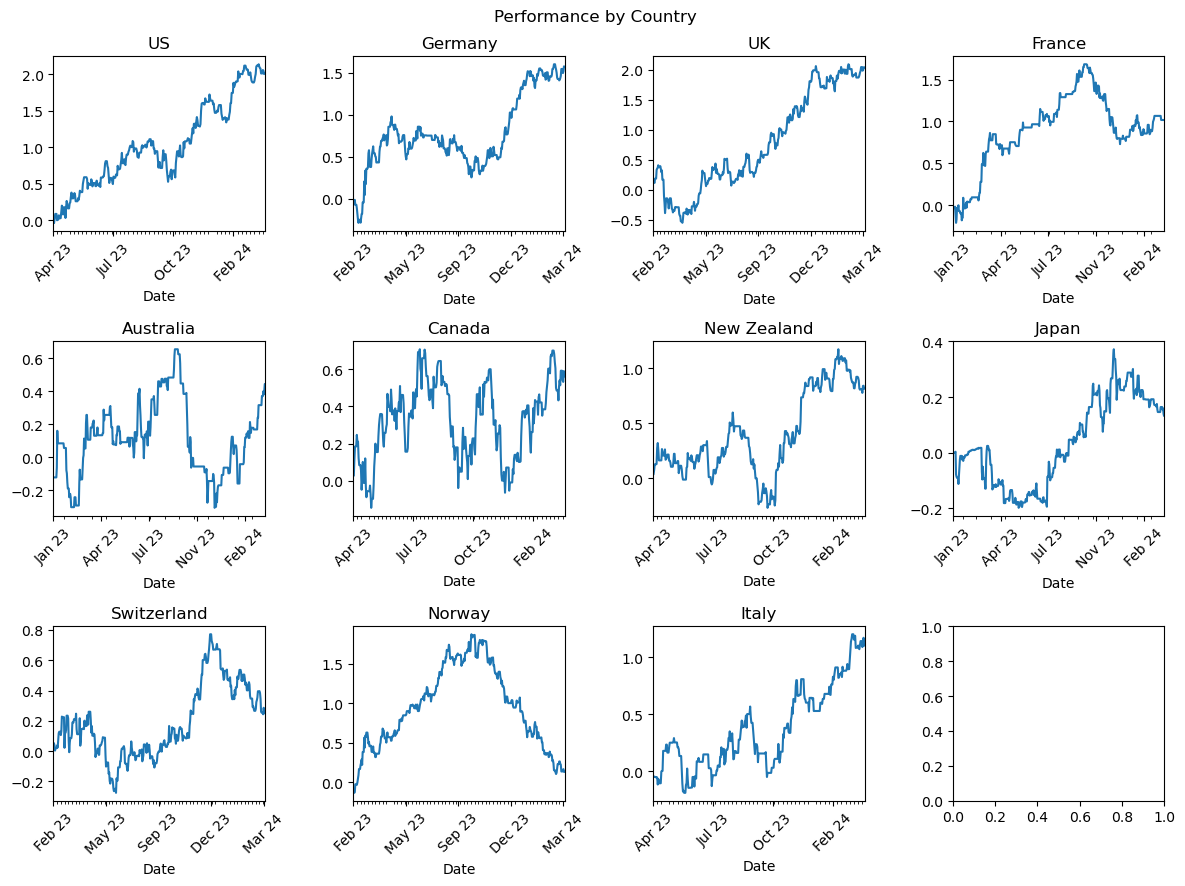

In [212]:
countries = list(codes.keys())
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
axs = axs.flatten()

for i, country in enumerate(countries):
    t, threshold = best_values[country]
    ax = axs[i]
    trade_data = trader(codes[country], t, threshold)
    trade_data.plot(ax=ax)
    ax.set_title(country)
    tick_positions = trade_data.index[::100]
    tick_labels = [d.strftime('%b %y') for d in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Performance by Country')
plt.tight_layout()
plt.show()